In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.cluster import hierarchy
import xgi
from collections import defaultdict
from itertools import combinations

from hyperfunctions import *
from Kumar_algorithm import *

In [2]:
edge_list_1 = [['a','b'],['c','d'],['a','b','c'],['a','b','d'],['e','f','g'],
               ['a','b','d','e'],['c','f','d','a'],['f','g'],['e','g','d'],['g','e'],
               ['e','f'],['a','h'],['i','h','j','k'],['j','e','g'],['i','j','k','b'],
               ['d','k','e','j'],['k','h'],['l','m','n'],['n','e','f'],['l','h','g'],['m','c']]

In [3]:
H = xgi.Hypergraph(edge_list_1)
nodes_list = list(H.nodes)

print(len(H.nodes), len(H.edges))

# Remove singletons
H.remove_edges_from(H.edges.singletons())
print(len(H.nodes), len(H.edges))

14 21
14 21


In [4]:
derivative = derivative_list(H)

In [5]:
method = "average"

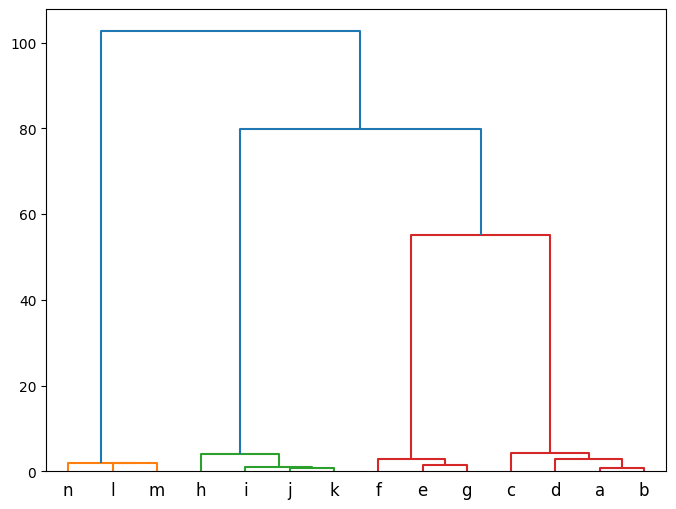

In [6]:
fig, ax = plt.subplots(1,1, figsize=(8,6))

Z = hierarchy.linkage(derivative, method)
dn = hierarchy.dendrogram(Z, labels = nodes_list, orientation='top', count_sort='ascending', ax=ax)

plt.show()

## General (us)

In [7]:
# Calculate all heights
Lamb = []
for n in range(len(Z)):
    if n>=1:
        lamb = Z[n][2] - Z[n-1][2]
        Lamb.append(lamb)

In [8]:
print(Lamb)

[0.08333333333333337, 0.25, 0.5, 0.5, 0.0, 0.75, 0.16666666666666696, 1.083333333333333, 0.33333333333333304, 50.72222222222223, 24.694444444444436, 22.88636363636364]


In [9]:
m = max(Lamb)
num_fusion = [i for i, j in enumerate(Lamb) if j == m]
index_max = num_fusion[0]
print(m, index_max)

50.72222222222223 9


In [10]:
h_cut = (Z[index_max+1][2] + Z[index_max][2])/2

In [11]:
cuttree = hierarchy.cut_tree(Z, height = h_cut)
Communities_dict = {}
for cont, i in enumerate(nodes_list):
    Communities_dict[i] = cuttree[cont][0]

In [12]:
cuttree

array([[0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [2],
       [2],
       [2],
       [2],
       [3],
       [3],
       [3]])

In [13]:
Communities_dict

{'a': 0,
 'b': 0,
 'c': 0,
 'd': 0,
 'e': 1,
 'f': 1,
 'g': 1,
 'h': 2,
 'i': 2,
 'j': 2,
 'k': 2,
 'l': 3,
 'm': 3,
 'n': 3}

In [14]:
Num_communities = len(set(Communities_dict.values()))

In [15]:
temp = []
res_dict = dict()
for key, val in Communities_dict.items():
    if val not in temp:
        temp.append(val)
        res_dict[key] = val
        
Communities_list = []        
for val in res_dict.values():
    comm = [k for k, v in Communities_dict.items() if v == val]
    Communities_list.append(comm)
    
print(Communities_list)
moda = len(Communities_list)

[['a', 'b', 'c', 'd'], ['e', 'f', 'g'], ['h', 'i', 'j', 'k'], ['l', 'm', 'n']]


## Modularity (us)

In [16]:
# Hallamos la matriz de incidencia del hipergrafo:
W = np.identity(len(H.edges))
I = xgi.convert.to_incidence_matrix(H, sparse=True, index=False)
    
# Define the delta_e list and D_v matrix
delta_e = [len(edge) for edge in H.edges.members()]
D_e = np.diag(delta_e)

# Compute the reduced adjacency matrix of the hypergraph
A = np.dot(I.dot(W), np.dot(np.linalg.inv((D_e - np.identity(len(H.edges)))), I.T.todense()))
A -= np.diag(np.diag(A))

In [17]:
# Create the associated graph
G1 = nx.from_numpy_array(A)

# Relabeling the nodes to meet with H
mapping = {}

for cont, node in enumerate(H.nodes):
    mapping[cont] = node
    
G = nx.relabel_nodes(G1, mapping)

In [18]:
Modularity = []
for n in range(len(H.nodes)):
    
    if n % 50 == 0:
        print(f'-- {n/len(H.nodes)}% --')
    
    cuttree = hierarchy.cut_tree(Z, n_clusters = n)
    Communities_dict = {}

    for cont, i in enumerate(nodes_list):
        Communities_dict[i] = cuttree[cont][0]

    # Remove duplicated values from the Communities_dict
    temp = []
    res_dict = dict()
    for key, val in Communities_dict.items():
        if val not in temp:
            temp.append(val)
            res_dict[key] = val
        
    Communities_list = []        
    for val in res_dict.values():
        comm = [k for k, v in Communities_dict.items() if v == val]
        Communities_list.append(comm)
        
    q = nx.community.modularity(G,Communities_list)
    
    Modularity.append(q)

-- 0.0% --


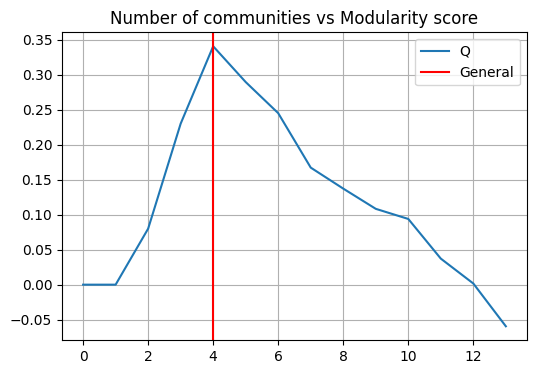

In [19]:
plt.figure(figsize=(6,4))
plt.title("Number of communities vs Modularity score")
plt.plot(range(len(H.nodes)), Modularity, label='Q')
plt.grid()
plt.axvline(Num_communities, color='r', label='General')

plt.legend()

plt.savefig("modularity_vs_moda.png")

*Conclusion*: the general method coincides with our modularity maximization in this example

In [20]:
m = max(Modularity)
num_fusion = [i for i, j in enumerate(Modularity) if j == m]
index_max = num_fusion[0]

print(f'Number of communities maximizing the modularity is: {index_max},')
print(f'with modularity: {m}')

Number of communities maximizing the modularity is: 4,
with modularity: 0.34055555555555556


In [21]:
communities_dict = communities(H, derivative, method, n_clusters=index_max)

nodeset_list = []
for nodeset in communities_dict.values():
    nodeset_list.append(nodeset)

print(nodeset_list)

[{'a', 'c', 'd', 'b'}, {'e', 'g', 'f'}, {'k', 'i', 'h', 'j'}, {'m', 'l', 'n'}]


## Modularity (Kumar)

In [27]:
clusters = IRMM_algorithm(H, tol=1e-3)
Communities_K = []
for comm in clusters:
    Community_K = []
    for node in comm:
        Community_K.append(mapping[node])
    Communities_K.append(Community_K)
    print(Community_K)


q = nx.community.modularity(G,Communities_K)
print(f'The modularity for this partition is: {q}')

It converge after 16 iterations
['a', 'b', 'c', 'd', 'm']
['e', 'f', 'g', 'l', 'n']
['i', 'j', 'k', 'h']
The modularity for this partition is: 0.32944444444444443


## Modularity (Kaminski)